## install necessary packages

In [ ]:
!pip install -q transformers accelerate
!pip install datasets -q
!pip install evaluate -q
!pip install url-normalize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00


## import necessary libraries

In [ ]:
import pandas as pd
import numpy as np

import json
import evaluate
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
!mv kaggle.json /root/.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
from url_normalize import url_normalize

#from kaggle import api

from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import TrainingArguments, Trainer
import torch

# calculating notebook score by DistilBERT Model

### Read Comments with no labels

In [ ]:
!gdown --id 1GUt_CHAZ7cylcwdGn9z4qhHoSwZAxDPD

In [ ]:
import pandas as pd

comments = pd.read_csv('comments_with_votes_with_parents.csv')

#### Eliminate comments written by the author of the notebook

In [ ]:
comments = comments[comments['DisplayName_kerneluser'] != comments['DisplayName_commentuser']]

#### Drop comments with no text

In [ ]:
comments.dropna(subset=['Text'], inplace=True)

#### Delete comments with more than 512 characters
#### Delete comments having exteral links (ads)

In [ ]:
comments = comments[comments['Text'].str.len() <= 256]
comments = comments[~comments['Message'].str.contains('<a')]

### Find and Eliminate non english comments with fasttext

In [ ]:
!pip install -q fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
--2023-05-29 05:04:31--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.39.89, 13.249.39.25, 13.249.39.6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.39.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M   225MB/s    in 0.6s    

2023-05-29 05:04:32 (225 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [ ]:
import fasttext as ft

ft_model = ft.load_model("./lid.176.bin")

def fasttext_language_predict(text, model = ft_model):
  text = text.replace('\n', " ")
  prediction = model.predict([text])
  return prediction


In [ ]:
lang = []
for text in comments['Text']:
  lang.append(fasttext_language_predict(text))

In [ ]:
not_ens = []
for i, detected_lang in enumerate(lang):
  if 'en' not in detected_lang[0][0][0] and detected_lang[1][0][0] > 0.7:
    not_ens.append(i)

#### Delete Non english comments

In [ ]:
comments.index = range(len(comments))
comments = comments.drop(not_ens, axis=0)

### Remove ads with Bert

In [ ]:
! pip install transformers -q

In [ ]:
! pip install datasets -q

In [ ]:
!pip install evaluate -q

In [ ]:
!gdown 1usKSVnfoWtIzcUvV0y5aSae4vKolXnXE

Downloading...
From: https://drive.google.com/uc?id=1usKSVnfoWtIzcUvV0y5aSae4vKolXnXE
To: /content/comments_samples_final.xlsx
100% 89.1k/89.1k [00:00<00:00, 57.3MB/s]


In [ ]:
import pandas as pd

df = pd.read_excel('comments_samples_final.xlsx').fillna(0)

In [ ]:
labels_df = df.drop(['Id', 'Text'], axis=1)
def col_to_list(row):
  return int('advertise' in list(labels_df.columns[row.eq(1)]))
labels = labels_df.apply(col_to_list, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(df['Text'], labels, test_size=0.13, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
from datasets import Dataset, DatasetDict

df_train = pd.DataFrame({'text': X_train, 'labels': y_train})
df_eval = pd.DataFrame({'text': X_eval, 'labels': y_eval})
df_test = pd.DataFrame({'text': X_test, 'labels': y_test})
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "eval": Dataset.from_pandas(df_eval),
    "test": Dataset.from_pandas(df_test)
    })

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("recall")

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
training_args.do_predict = True
training_args.do_train = True
training_args.do_eval = True

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42),
    eval_dataset=tokenized_datasets["eval"].shuffle(seed=42),
    compute_metrics=compute_metrics,
)

In [ ]:
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Recall
1,No log,0.132351,0.750000
2,No log,0.095873,0.875000
3,No log,0.104637,0.875000


In [ ]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        3.0
  total_flos               =   259076GF
  train_loss               =     0.1105
  train_runtime            = 0:01:38.14
  train_samples_per_second =     21.396
  train_steps_per_second   =       2.69


In [ ]:
# Evaluation

metrics = trainer.evaluate(eval_dataset=tokenized_datasets["eval"].shuffle(seed=42))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_loss               =     0.1046
  eval_recall             =      0.875
  eval_runtime            = 0:00:02.51
  eval_samples_per_second =     55.604
  eval_steps_per_second   =      7.149


In [ ]:
# Prediction

predictions, labels, metrics = trainer.predict(tokenized_datasets["test"], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

***** predict metrics *****
  predict_loss               =     0.0753
  predict_recall             =     0.8824
  predict_runtime            = 0:00:03.62
  predict_samples_per_second =     64.634
  predict_steps_per_second   =      8.286


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(predictions, labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       217
           1       0.88      0.88      0.88        17

    accuracy                           0.98       234
   macro avg       0.94      0.94      0.94       234
weighted avg       0.98      0.98      0.98       234



#### Remove ads from all comments

In [ ]:
comments_dataset = Dataset.from_pandas(comments[["Text"]].rename(columns={'Text': 'text'}))
tokenized_comments = comments_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/310729 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(tokenized_comments, metric_key_prefix="predict")

In [ ]:
trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions_binary = np.argmax(predictions[0], axis=1)

***** predict metrics *****
  predict_loss               =     0.0753
  predict_recall             =     0.8824
  predict_runtime            = 0:00:03.62
  predict_samples_per_second =     64.634
  predict_steps_per_second   =      8.286


In [ ]:
comments_no_ad = comments[~np.array(predictions_binary).astype(bool)]

In [ ]:
comments_no_ad.to_csv('comments-no-ad.csv', index=False)

### Predict comments related to code comprehension with Bert

In [ ]:
import pandas as pd

df = pd.read_excel('comments_samples_final.xlsx').fillna(0)

In [ ]:
df = df[~(df['advertise'] == 1)]

In [ ]:
labels_df = df.drop(['Id', 'Text'], axis=1)
def col_to_list(row):
  return int('comperenension' in list(labels_df.columns[row.eq(1)]))
labels = labels_df.apply(col_to_list, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(df['Text'], labels, test_size=0.13, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
from datasets import Dataset, DatasetDict

df_train = pd.DataFrame({'text': X_train, 'labels': y_train})
df_eval = pd.DataFrame({'text': X_eval, 'labels': y_eval})
df_test = pd.DataFrame({'text': X_test, 'labels': y_test})
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "eval": Dataset.from_pandas(df_eval),
    "test": Dataset.from_pandas(df_test)
    })

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/213 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
training_args.do_predict = True
training_args.do_train = True
training_args.do_eval = True

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42),
    eval_dataset=tokenized_datasets["eval"].shuffle(seed=42),
    compute_metrics=compute_metrics,
)

In [ ]:
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.282353,0.921875
2,No log,0.339412,0.906250
3,No log,0.401581,0.898438


In [ ]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        3.0
  total_flos               =   235389GF
  train_loss               =     0.2739
  train_runtime            = 0:01:34.70
  train_samples_per_second =     20.147
  train_steps_per_second   =      2.534


In [ ]:
# Evaluation

metrics = trainer.evaluate(eval_dataset=tokenized_datasets["eval"].shuffle(seed=42))
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.8984
  eval_loss               =     0.4016
  eval_runtime            = 0:00:02.09
  eval_samples_per_second =     60.989
  eval_steps_per_second   =      7.624


In [ ]:
# Prediction

predictions, labels, metrics = trainer.predict(tokenized_datasets["test"], metric_key_prefix="predict")
trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)
predictions = np.argmax(predictions, axis=1)

***** predict metrics *****
  predict_accuracy           =     0.9061
  predict_loss               =     0.3656
  predict_runtime            = 0:00:03.49
  predict_samples_per_second =     60.964
  predict_steps_per_second   =      7.728


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions, labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        77
           1       0.94      0.91      0.93       136

    accuracy                           0.91       213
   macro avg       0.90      0.90      0.90       213
weighted avg       0.91      0.91      0.91       213



In [ ]:
# Predict all comments

comments_dataset = Dataset.from_pandas(comments_no_ad[["Text"]].rename(columns={'Text': 'text'}))
tokenized_comments = comments_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/305708 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(tokenized_comments, metric_key_prefix="predict")

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 8


In [ ]:
trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions_binary = np.argmax(predictions[0], axis=1)

***** predict metrics *****
  predict_accuracy           =     0.9202
  predict_loss               =     0.3988
  predict_runtime            = 0:00:04.04
  predict_samples_per_second =     52.609
  predict_steps_per_second   =      6.669


In [ ]:
comments_no_ad_labeled = comments_no_ad[~np.array(predictions_binary).astype(bool)]

In [ ]:
comments_no_ad.to_csv('comments-scored.csv', index=False)

# expert questionnaire and create Ground Truth

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('experts.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Ensure the labels are integers
df['label'] = df['label'].astype(int)
df['Expert 1'] = df['Expert 1'].astype(int)
df['Expert 2'] = df['Expert 2'].astype(int)
df['Expert 3'] = df['Expert 3'].astype(int)

# Initialize variables
n = len(df)  # Number of subjects
k = 3        # Number of raters
categories = 2  # Number of categories (0 and 1)

# Create a DataFrame to store the ratings of each expert
ratings = df[['Expert 1', 'Expert 2', 'Expert 3']].values

# Calculate the agreement matrix
agreement_matrix = [[0] * categories for _ in range(n)]
for i, row in enumerate(ratings):
    for j in range(categories):
        agreement_matrix[i][j] = sum(row == j)

# Calculate the marginal probabilities
p_j = [sum([1 for row in agreement_matrix if row[j] == k]) / (n * k) for j in range(categories)]
p_i = [sum(row) / (k * n) for row in agreement_matrix]

# Calculate P_e (expected agreement)
P_e = sum(p_j[i] ** 2 for i in range(categories))

# Calculate P
P = [(sum(row[i] ** 2 for i in range(categories)) - k) / (k * (k - 1)) for row in agreement_matrix]
P_bar = sum(P) / n

# Calculate Fleiss' Kappa
kappa = (P_bar - P_e) / (1 - P_e)

print("Fleiss' Kappa:", kappa)


Fleiss' Kappa: 0.8135457288575881


# Model criteria and compare against Ground Truth

### New Ground Truth

In [ ]:
import pandas as pd

df = pd.read_csv('experts.csv')
df['label'] = df['label'].astype(int)

### Calculate combined score

#### Download all kernels

In [ ]:
!wget https://zenodo.org/records/10317389/files/notebook_metrics.csv?download=1

--2024-04-15 13:47:29--  https://zenodo.org/records/10317389/files/notebook_metrics.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121066051 (115M) [text/plain]
Saving to: ‘notebook_metrics.csv?download=1’

notebook_metrics.cs 100%[===================>] 115.46M   969KB/s    in 2m 24s  

2024-04-15 13:49:53 (821 KB/s) - ‘notebook_metrics.csv?download=1’ saved [121066051/121066051]



In [ ]:
import pandas as pd

feat_df = pd.read_csv('notebook_metrics.csv?download=1', low_memory=False)

In [ ]:
feat_df = feat_df.drop_duplicates(subset=['kernel_id'])
# feat_df['kernel_id'] = feat_df['kernel_id'].unique()

In [ ]:
feat_df

,kernel_id,LOC,BLC,UDF,I,EH,NVD,NEC,S,P,...,CC,MC,MeanWMC,MeanLMC,H1,H2,H3,MW,LMC,PT
0,12034794,68,0,3.0,6,0.0,0.0,0.0,15.0,68.0,...,5,6.0,35.166666666666664,1.6666666666666667,0.0,3.0,0.0,211.0,10.0,5
1,12035120,78,0,3.0,6,0.0,1.0,1.0,17.0,82.0,...,10,11.0,19.90909090909091,1.3636363636363635,0.0,3.0,1.0,219.0,15.0,5
2,12035356,68,0,3.0,6,0.0,0.0,0.0,15.0,68.0,...,5,6.0,35.166666666666664,1.6666666666666667,0.0,3.0,0.0,211.0,10.0,5
3,12035387,76,0,3.0,6,0.0,0.0,0.0,17.0,77.0,...,8,9.0,23.88888888888889,1.4444444444444444,0.0,3.0,1.0,215.0,13.0,5
4,12035410,84,0,3.0,6,0.0,2.0,2.0,19.0,86.0,...,11,12.0,19.916666666666668,1.3333333333333333,0.0,3.0,2.0,239.0,16.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517487,9970903,770,1,15.0,59,1.0,2.0,2.0,102.0,422.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
517488,9991246,197,0,2.0,17,0.0,1.0,2.0,22.0,117.0,...,11,1.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,0
517489,9995660,137,2,0.0,19,0.0,0.0,0.0,16.0,126.0,...,50,3.0,2.6666666666666665,1.0,0.0,0.0,0.0,8.0,3.0,0
517490,9996831,293,0,4.0,15,0.0,8.0,1.0,9.0,44.0,...,19,13.0,115.76923076923076,5.846153846153846,1.0,6.0,4.0,1505.0,76.0,1


In [ ]:
import os

api_token = {"username":"_","key":"_"}

import json

with open('kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 kaggle.json

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
!kaggle datasets download kaggle/meta-kaggle -f UserAchievements.csv

 94% 377M/401M [00:04<00:00, 69.2MB/s]
100% 401M/401M [00:04<00:00, 91.7MB/s]


In [ ]:
!unzip UserAchievements.csv.zip

Archive:  UserAchievements.csv.zip
  inflating: UserAchievements.csv    


In [ ]:
import pandas as pd

user_achievements = pd.read_csv('UserAchievements.csv', usecols=['UserId', 'AchievementType', 'Tier', 'TierAchievementDate'])

In [ ]:
len(user_achievements)

71525000

In [ ]:
user_achievements.sort_values(by=['UserId'], inplace=True)

In [ ]:
user_achievements['UserId'].head(20)

0             1
1026073       1
10923747      1
900           1
10923748    368
902         368
1           368
901         368
903         381
904         381
11455864    381
2           381
11426705    383
1925796     383
585593      383
3           383
1168801     384
10924849    384
4           384
543481      384
Name: UserId, dtype: int64

In [ ]:
!kaggle datasets download kaggle/meta-kaggle -f Kernels.csv

 73% 33.0M/45.4M [00:00<00:00, 67.5MB/s]
100% 45.4M/45.4M [00:00<00:00, 78.8MB/s]


In [ ]:
!kaggle datasets download kaggle/meta-kaggle -f Users.csv

 96% 290M/301M [00:03<00:00, 76.9MB/s]
100% 301M/301M [00:03<00:00, 86.9MB/s]


In [ ]:
!unzip Kernels.csv.zip

Archive:  Kernels.csv.zip
  inflating: Kernels.csv             


In [ ]:
!unzip Users.csv.zip

Archive:  Users.csv.zip
  inflating: Users.csv               


In [ ]:
kernels = pd.read_csv('Kernels.csv')

In [ ]:
users = pd.read_csv('Users.csv')

In [ ]:
kernels_with_username = pd.merge(kernels, users[['Id', 'UserName', 'PerformanceTier', ]].rename(columns={'Id': 'AuthorUserId'}), on='AuthorUserId', how='inner')

In [ ]:
all_kernels = pd.merge(feat_df, kernels_with_username[['Id', 'TotalVotes', 'TotalViews', 'CurrentUrlSlug', 'UserName', 'PerformanceTier' ]].rename(columns={'Id': 'kernel_id'}), on='kernel_id', how='inner')

In [ ]:
all_kernels = all_kernels[['kernel_id', 'TotalVotes', 'TotalViews', 'CurrentUrlSlug', 'UserName', 'PerformanceTier', ]]

#### Download comments

In [ ]:
!gdown 1X7A-qqaMhgWHe5KZd_jrHFtCttHdwpZS

Downloading...
From: https://drive.google.com/uc?id=1X7A-qqaMhgWHe5KZd_jrHFtCttHdwpZS
To: /content/comments_by_votes.csv
100% 30.9M/30.9M [00:00<00:00, 77.6MB/s]


In [ ]:
import pandas as pd

comments = pd.read_csv('comments_by_votes.csv') # comments_no_ad

In [ ]:
comments.head()

,CommentId,PostUserId,KernelId,AuthorUserId,UserName,CurrentUrlSlug,TotalViews,TotalVotes,PerformanceTier_kerneluser,PerformanceTier_commentuser,bert_score,CommentVote
0,80401,195039,4811,28963,datacanary,hello-this-is-my-script,31,0,2,5,0,0.0
1,80882,195039,5111,2505,jeffmoser,testing-out-non-inline-rmarkdown,115,0,5,5,0,0.0
2,80900,195039,5111,2505,jeffmoser,testing-out-non-inline-rmarkdown,115,0,5,5,0,0.0
3,80920,195039,5111,2505,jeffmoser,testing-out-non-inline-rmarkdown,115,0,5,5,0,0.0
4,80946,195039,5111,2505,jeffmoser,testing-out-non-inline-rmarkdown,115,0,5,5,0,0.0


In [ ]:
kernel_quality = comments.groupby(by=['KernelId','AuthorUserId','UserName', 'CurrentUrlSlug', 'TotalViews', 'TotalVotes',
                      'PerformanceTier_kerneluser']).sum().reset_index()

In [ ]:
kernel_quality.drop(columns=['CommentId'], inplace=True)

In [ ]:
# kernel_quality.drop(columns=['PerformanceTier_kerneluser','CommentId'], inplace=True)

In [ ]:
# kq = kernel_quality.sort_values(by=['TotalVotes', 'TotalViews'], ascending=[True, False])
# first_500 = kq.head(500)
# last_500 = kq.tail(500)

# new_df = pd.concat([first_500, last_500], ignore_index=True)
# new_df.to_csv('1000_notebook_for_CodeBERT_finetune.csv', index=False)

In [ ]:
import numpy as np

kernel_quality['pure_topic_score'] = kernel_quality['bert_score'] * (kernel_quality['CommentVote'] + 1)
kernel_quality['topic_score'] = (kernel_quality['bert_score'] * (kernel_quality['CommentVote'] + 1) + 10 ) / np.sqrt(kernel_quality['TotalViews'])

In [ ]:
augmented_kernel_quality = pd.merge(kernel_quality, all_kernels.rename(columns={'kernel_id': 'KernelId'}), on='KernelId', how='outer')

In [ ]:
import math

augmented_kernel_quality['topic_score'] = augmented_kernel_quality.apply(lambda x: (10 / np.sqrt(x['TotalViews_y']))  if math.isnan(x['topic_score'])  else x['topic_score'], axis=1)

<ipython-input-34-9b355f5f1e78>:3: RuntimeWarning: divide by zero encountered in scalar divide
  augmented_kernel_quality['topic_score'] = augmented_kernel_quality.apply(lambda x: (10 / np.sqrt(x['TotalViews_y']))  if math.isnan(x['topic_score'])  else x['topic_score'], axis=1)


In [ ]:
augmented_kernel_quality['TotalViews'] = augmented_kernel_quality.apply(lambda x: x['TotalViews_x']  if math.isnan(x['TotalViews_y']) else x['TotalViews_y'], axis=1)

In [ ]:
augmented_kernel_quality['UserName'] = augmented_kernel_quality.apply(lambda x: x['UserName_x']  if pd.isnull(x['UserName_y']) else x['UserName_y'], axis=1)

In [ ]:
augmented_kernel_quality['TotalVotes'] = augmented_kernel_quality.apply(lambda x: x['TotalVotes_x']  if math.isnan(x['TotalVotes_y']) else x['TotalVotes_y'], axis=1)

In [ ]:
augmented_kernel_quality['CurrentUrlSlug'] = augmented_kernel_quality.apply(lambda x: x['CurrentUrlSlug_x']  if pd.isnull(x['CurrentUrlSlug_y']) else x['CurrentUrlSlug_y'], axis=1)

In [ ]:
augmented_kernel_quality['PerformanceTier_kerneluser'] = augmented_kernel_quality.apply(lambda x: x['PerformanceTier_kerneluser']  if pd.isnull(x['PerformanceTier']) else x['PerformanceTier'], axis=1)

In [ ]:
augmented_kernel_quality.drop(['TotalViews_x', 'TotalViews_y', 'TotalVotes_x', 'TotalVotes_y', 'CurrentUrlSlug_x', 'CurrentUrlSlug_y', 'UserName_x', 'UserName_y', 'PerformanceTier'], inplace=True, axis=1)

In [ ]:
augmented_kernel_quality

,KernelId,AuthorUserId,PerformanceTier_kerneluser,PostUserId,PerformanceTier_commentuser,bert_score,CommentVote,pure_topic_score,topic_score,TotalViews,UserName,TotalVotes,CurrentUrlSlug
0,2,3716.0,2.0,836085.0,0.0,0.0,0.0,0.0,0.107002,8734.0,dchudz,13.0,rf-proximity
1,14,993.0,5.0,378544.0,5.0,1.0,4.0,5.0,0.143032,10998.0,benhamner,11.0,installed-r-packages
2,15,993.0,5.0,3062474.0,3.0,0.0,16.0,0.0,0.055199,32820.0,benhamner,42.0,example-handwritten-digits
3,17,993.0,5.0,1295396.0,2.0,0.0,0.0,0.0,0.095647,10931.0,benhamner,8.0,pixel-mean-and-variances-by-digit
4,21,993.0,5.0,9760541.0,13.0,4.0,33.0,136.0,0.604598,58314.0,benhamner,98.0,random-forest-benchmark-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
518362,9970903,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.324785,948.0,bhavesjain,3.0,modanet-maskrcnn-10
518363,9991246,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.677285,218.0,evketakrmak,2.0,sevket-akirmak-makine-final
518364,9995660,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.803219,155.0,cosmosankur,2.0,keras-code-with-95-percent-accuracy-on-ad-click
518365,9996831,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.527780,359.0,stephenofarrell,3.0,identifying-patterns-in-lol-level-ones


### delete outliers

<Axes: >

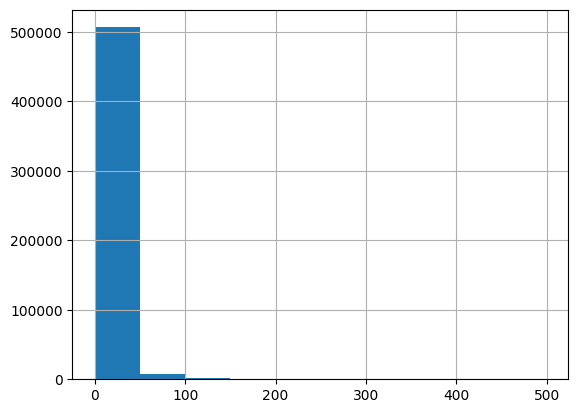

In [ ]:
kq = augmented_kernel_quality[augmented_kernel_quality['TotalVotes'] < 500]

kq['TotalVotes'].hist()

In [ ]:
len(augmented_kernel_quality)

518367

In [ ]:
augmented_kernel_quality = augmented_kernel_quality[augmented_kernel_quality['TotalVotes'] < 500]

In [ ]:
len(augmented_kernel_quality)

518019

<Axes: >

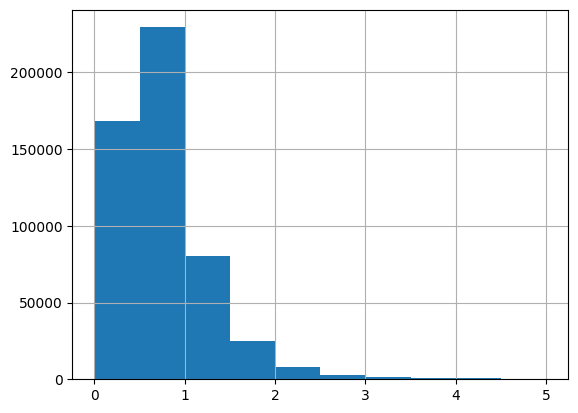

In [ ]:
kq2 = augmented_kernel_quality[augmented_kernel_quality['topic_score'] < 5]

kq2['topic_score'].hist()

In [ ]:
augmented_kernel_quality = augmented_kernel_quality[augmented_kernel_quality['topic_score'] < 5]

In [ ]:
len(augmented_kernel_quality)

517409

In [ ]:
augmented_kernel_quality['score_scaled'] = (augmented_kernel_quality['topic_score'] - augmented_kernel_quality['topic_score'].min()) / (augmented_kernel_quality['topic_score'].max() - augmented_kernel_quality['topic_score'].min() )
augmented_kernel_quality['vote_scaled'] = ((augmented_kernel_quality['TotalVotes'] - augmented_kernel_quality['TotalVotes'].min())) / (augmented_kernel_quality['TotalVotes'].max() - augmented_kernel_quality['TotalVotes'].min())
augmented_kernel_quality['combined_score'] = augmented_kernel_quality['score_scaled'] + augmented_kernel_quality['vote_scaled']

In [ ]:
def metrics_reports(criterion):
  from sklearn.metrics import classification_report
  augmented_kernel_quality.sort_values(by=criterion, inplace=True)
  X = augmented_kernel_quality.copy()
  split_factor = 0.5
  zeros_len = int(split_factor * len(X))
  X[f'binary_{criterion}'] = [0 for _ in range(zeros_len)] + [1 for _ in range(len(X) - zeros_len)]
  X = X.loc[:,~X.columns.duplicated()]
  result = pd.merge(X, df, left_on='KernelId', right_on='KernelId', how='inner')
  result = result[result[f'binary_{criterion}'].isna() != True]
  print(classification_report(y_pred = result[f'binary_{criterion}'], y_true= result['expert_score']))
  return result

In [ ]:
# New augmented approach

result= metrics_reports('topic_score')

              precision    recall  f1-score   support

           0       0.65      0.98      0.78       565
           1       0.94      0.38      0.55       484

    accuracy                           0.70      1049
   macro avg       0.79      0.68      0.66      1049
weighted avg       0.78      0.70      0.67      1049



In [ ]:
# New augmented approach

r = metrics_reports('vote_scaled')

              precision    recall  f1-score   support

           0       0.94      0.26      0.41       565
           1       0.53      0.98      0.69       484

    accuracy                           0.59      1049
   macro avg       0.73      0.62      0.55      1049
weighted avg       0.75      0.59      0.54      1049



In [ ]:
# New augmented approach

result = metrics_reports('combined_score')

              precision    recall  f1-score   support

           0       0.89      0.82      0.86       565
           1       0.81      0.88      0.84       484

    accuracy                           0.85      1049
   macro avg       0.85      0.85      0.85      1049
weighted avg       0.85      0.85      0.85      1049



In [ ]:
augmented_kernel_quality

,KernelId,AuthorUserId,PerformanceTier_kerneluser,PostUserId,PerformanceTier_commentuser,bert_score,CommentVote,pure_topic_score,topic_score,TotalViews,UserName,TotalVotes,CurrentUrlSlug,score_scaled,vote_scaled,combined_score
271163,12527393,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.014028,508194.0,stephan,1.0,4-7-finding-relationships-and-transformations,0.001374,0.002012,0.003386
453771,8659234,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.032233,96251.0,benjaminschreiber,0.0,markov-decision-processes,0.005020,0.000000,0.005020
274904,13001688,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.032848,92678.0,pragyanshusingh,0.0,nov21-mbert,0.005144,0.000000,0.005144
443515,8026490,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.024744,163328.0,pratikrandad,1.0,executing-multiple-sql-queries-using-python,0.003520,0.002012,0.005532
329283,227268,NaN,4.0,NaN,NaN,NaN,NaN,NaN,0.036755,74025.0,kmader,0.0,qbi-comple-object-analysis-skeletonization,0.005926,0.000000,0.005926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10481,925374,1013858.0,2.0,39869793.0,39.0,20.0,45.0,920.0,4.768290,40558.0,wesamelshamy,386.0,trackml-problem-explanation-and-data-exploration,0.953665,0.776660,1.730325
9104,672341,813035.0,2.0,98081465.0,26.0,15.0,85.0,1290.0,3.781995,159056.0,itoeiji,494.0,deep-reinforcement-learning-on-stock-data,0.756108,0.993964,1.750071
53387,15434135,1723677.0,4.0,216160250.0,119.0,24.0,27.0,672.0,4.088967,33534.0,cdeotte,465.0,part-2-rapids-tfidfvectorizer-cv-0-700,0.817595,0.935614,1.753209
17295,2892223,727004.0,4.0,209625493.0,86.0,60.0,17.0,1080.0,4.783049,60174.0,artgor,458.0,eda-feature-engineering-and-model-interpretation,0.956621,0.921529,1.878151


In [ ]:
augmented_kernel_quality.to_csv('augmented_kernel_quality.csv', index=False)

In [ ]:
!cp augmented_kernel_quality.csv drive/MyDrive/Meta_Kaggle/